In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import csv as csv
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA


df = pd.read_csv('train.csv.gz')
df

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan
...,...,...,...,...,...,...,...,...,...,...
26724,A702446,NaN,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White
26725,A718934,NaN,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black


In [22]:
feature_cols = ['AnimalType', 'DateTime','SexuponOutcome', 'Breed', 'Color', 'AgeuponOutcome']
X = df[feature_cols]
y = df['OutcomeType']


In [23]:
#This changes the ageuponoutcome to integers
def age_to_years(item):
    if type(item) is str:
        item = [item]
    ages_in_years = np.zeros(len(item))
    for i in range(len(item)):
        if type(item[i]) is str:
            if 'day' in item[i]:
                ages_in_years[i] = int(item[i].split(' ')[0])/365
            if 'week' in item[i]:
                ages_in_years[i] = int(item[i].split(' ')[0])/52.1429
            if 'month' in item[i]:
                ages_in_years[i] = int(item[i].split(' ')[0])/12
            if 'year' in item[i]:
                ages_in_years[i] = int(item[i].split(' ')[0])    
        else:
            ages_in_years[i] = 0
    return ages_in_years

df['AgeuponOutcome'] = age_to_years(df['AgeuponOutcome']).round(1)


<Axes: xlabel='AnimalType', ylabel='count'>

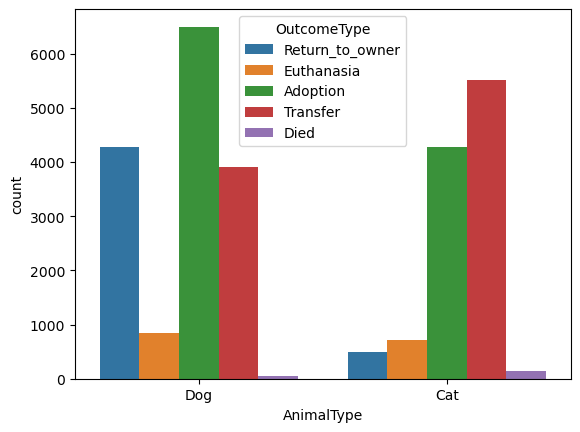

In [24]:
#Colorful graph for cats and dogs that happened when in the shelter
sns.countplot(x="AnimalType",hue="OutcomeType",data=df)

In [25]:
#Lable encoder helps change the strings to integers

X.loc[:, 'AnimalType'] = preprocessing.LabelEncoder().fit_transform(X['AnimalType'])
X.loc[:, 'SexuponOutcome'] = preprocessing.LabelEncoder().fit_transform(X['SexuponOutcome'])
X.loc[:, 'Breed'] = preprocessing.LabelEncoder().fit_transform(X['Breed'])
X.loc[:, 'Color'] = preprocessing.LabelEncoder().fit_transform(X['Color'])
X.loc[:, 'AgeuponOutcome'] = preprocessing.LabelEncoder().fit_transform(X['AgeuponOutcome'])
y = preprocessing.LabelEncoder().fit_transform(y)

In [26]:
# Ensure we are working on a copy of the DataFrame
X = X.copy()

X['DateTime'] = pd.to_datetime(X['DateTime'], errors='coerce')
# Create new columns for day of the week, month, and year
X['dow'] = X['DateTime'].dt.dayofweek  # Day of week
X['month'] = X['DateTime'].dt.month    # Month
X['year'] = X['DateTime'].dt.year      # Year
X = X.drop(columns=['DateTime'])
X = X.fillna(-1)
X = X.astype({col: 'int8' if X[col].max() < 128 else 'int16' for col in X.select_dtypes(include=['int', 'float']).columns})

print(X.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   AnimalType      26729 non-null  int8 
 1   SexuponOutcome  26729 non-null  int8 
 2   Breed           26729 non-null  int16
 3   Color           26729 non-null  int16
 4   AgeuponOutcome  26729 non-null  int8 
 5   dow             26729 non-null  int8 
 6   month           26729 non-null  int8 
 7   year            26729 non-null  int16
dtypes: int16(3), int8(5)
memory usage: 287.3 KB
None


C:\Users\Tuna7\AppData\Local\Temp\ipykernel_1220\3302968231.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(-1)


In [27]:
#CROSS VALIDATION (Takes about 2 minutes to load up, n_estimators is the reason why 100-1000 if you want to change it to load faster)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

rfc = RandomForestClassifier(n_estimators=100, random_state=50, n_jobs=-1)  

rfc.fit(X_train, y_train)

cvs = cross_val_score(rfc, X, y, cv=3, scoring='accuracy')  

print("Cross-validation Accuracy:", np.mean(cvs))


Cross-validation Accuracy: 0.6150250588346896


In [28]:
#RandomForestClassifier
rfcacc = rfc.score(X_test, y_test)
print("Random Forest Classifier Accuracy:", rfcacc)

Random Forest Classifier Accuracy: 0.6209003616411024


In [29]:
#LINEAR Regression
linr = LinearRegression()
linr.fit(X_train, y_train)

#PREDICTION
y_prediction = linr.predict(X_test)
print("Prediction Stage:", y_prediction.mean())

#RMSE
mse = metrics.mean_squared_error(y_test, y_prediction)
rmse = np.sqrt(mse)
print("Root Mean Square Error",rmse)


Prediction Stage: 2.0883350356084645
Root Mean Square Error 1.6841890341664214


In [30]:
#DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=None,)
dtc.fit(X_train, y_train)
y_predict = dtc.predict(X_test)
dtcacc = accuracy_score(y_test, y_predict)
print("Decision Tree Classifier Accuracy : ", dtcacc)


Decision Tree Classifier Accuracy :  0.5354782391819429


In [31]:
#KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train, y_train)
knnpred = knn.predict(X_test)
knnacc = accuracy_score(y_test, knnpred)
print("K Nearest Neighbors Accuracy:", knnacc)

K Nearest Neighbors Accuracy: 0.4889637111859334


In [32]:
#LogRegression
logr = LogisticRegression()
logr.fit(X_train, y_train)
y_predict_lr = logr.predict(X_test)
y_predict_prob_lr = logr.predict_proba(X_test)
print("Predicted Label:", y_predict_lr.mean())
print("Estimated likelihood of both label:", y_predict_prob_lr.mean())
print("Estimated likelihood of label of 1 :", y_predict_prob_lr[:,1].mean())

Predicted Label: 0.7464771168474872
Estimated likelihood of both label: 0.2
Estimated likelihood of label of 1 : 0.007115855579122227


c:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


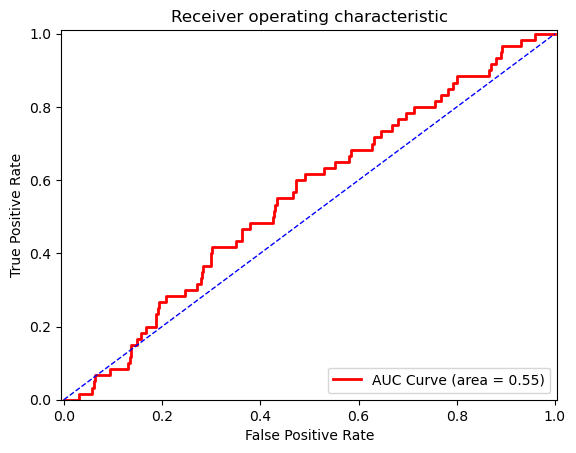

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)


AUC = metrics.auc(fpr, tpr)
plt.figure()

plt.plot(fpr, tpr, color='red', lw=2, 
         label='AUC Curve (area = %0.2f)' % AUC)

plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

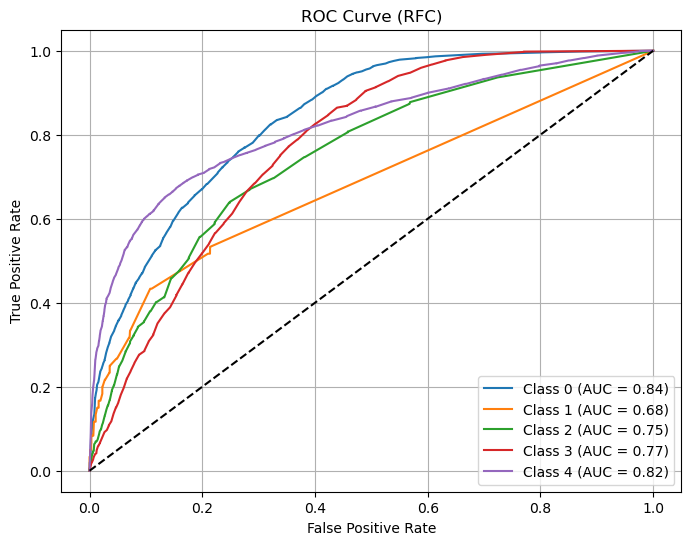

In [34]:
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
y_score = rfc.predict_proba(X_test)
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], np.array(y_score)[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], np.array(y_score)[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (RFC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

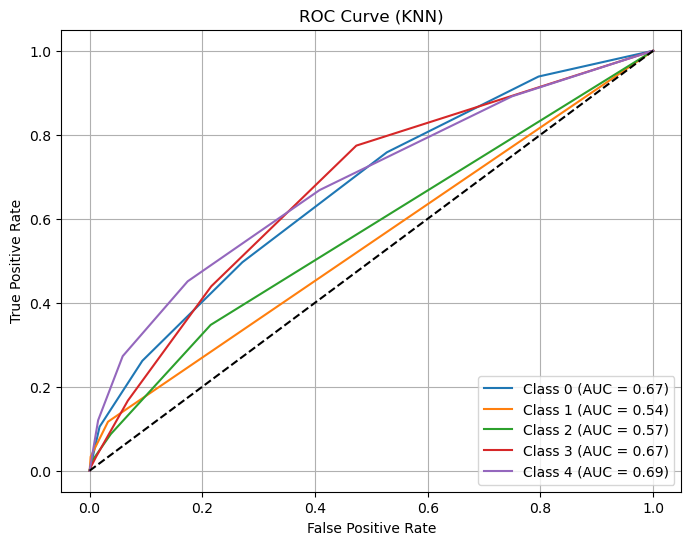

In [35]:
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
y_score = knn.predict_proba(X_test)
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], np.array(y_score)[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], np.array(y_score)[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (KNN)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

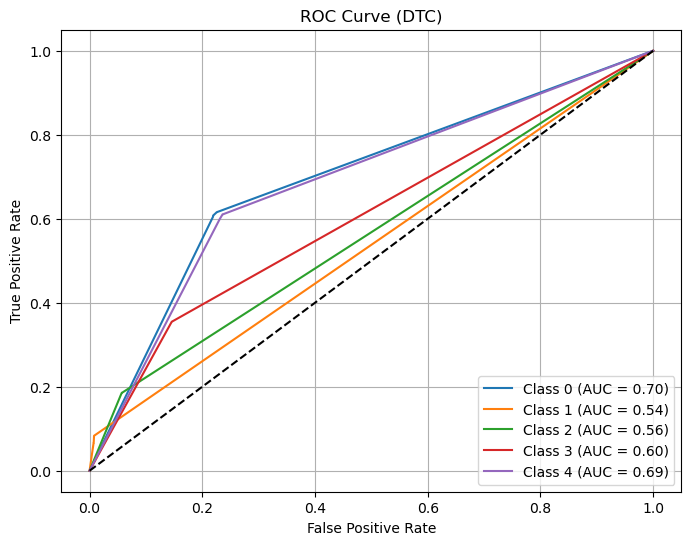

In [36]:
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
y_score = dtc.predict_proba(X_test)
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], np.array(y_score)[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], np.array(y_score)[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (DTC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


--- Feature Selection Using Decision Tree Importance ---
Decision Tree Feature Importances:
           Feature  Importance
1  SexuponOutcome    0.200980
3           Color    0.178226
6           month    0.147331
2           Breed    0.144901
4  AgeuponOutcome    0.134681
5             dow    0.102985
7            year    0.053162
0      AnimalType    0.037734


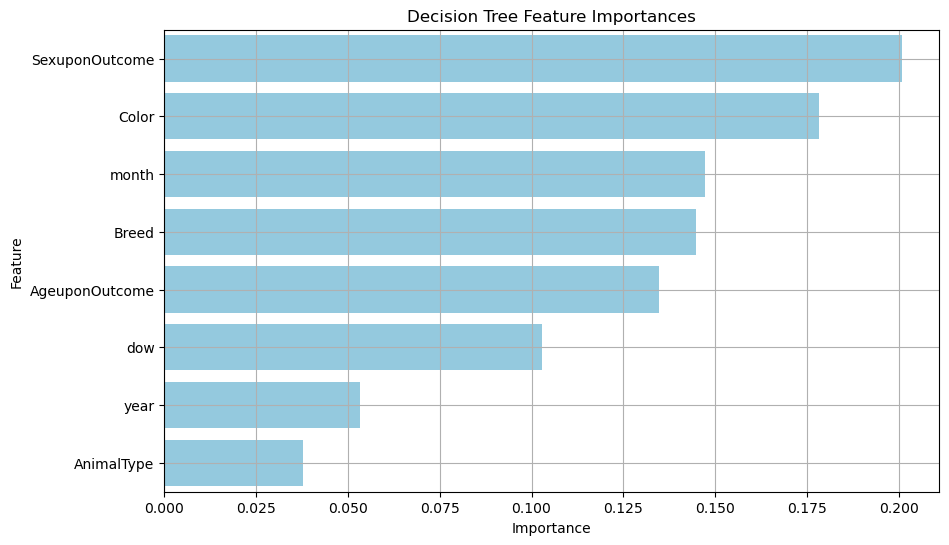

Top 2 features based on Decision Tree importance: ['SexuponOutcome', 'Color']

--- Feature Selection Using Logistic Regression Coefficients ---
Logistic Regression Feature Coefficients:
           Feature  Coefficient
1  SexuponOutcome     0.628328
5             dow     0.203929
6           month     0.067574
0      AnimalType     0.065995
2           Breed     0.062534
3           Color     0.021334
4  AgeuponOutcome     0.009634
7            year     0.008587


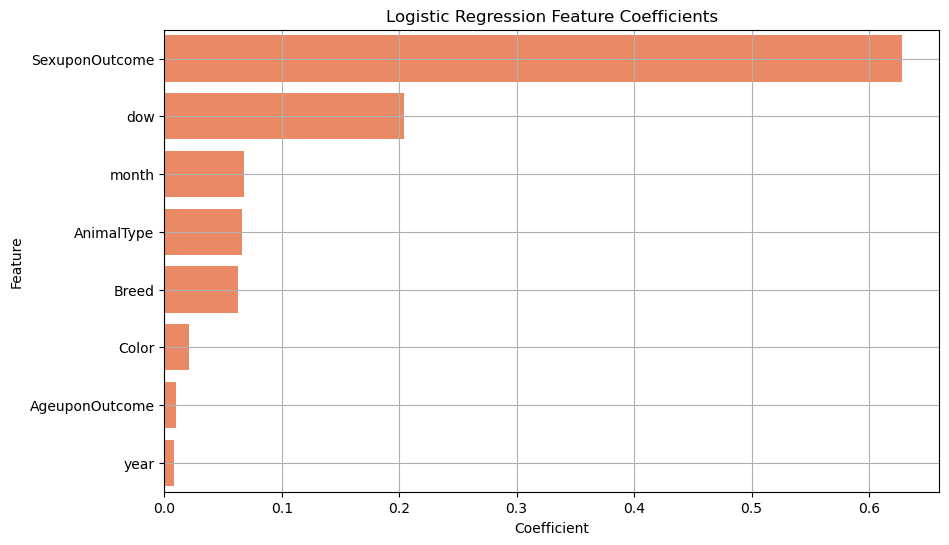

Top 2 features based on Logistic Regression coefficients: ['SexuponOutcome', 'dow']

--- Feature Extraction Using PCA ---


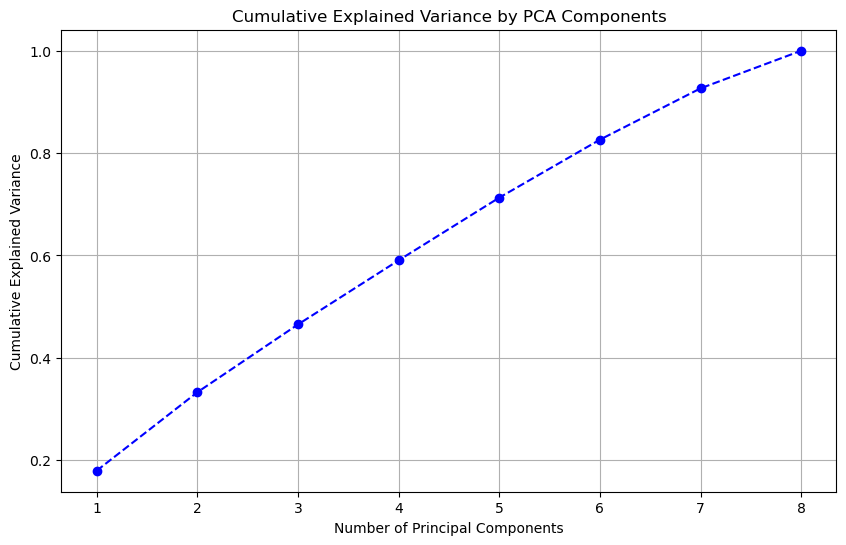


--- Classifier Evaluation ---

Evaluating classifiers on Decision Tree Features...
Random Forest Accuracy: 0.6063100137174211
KNN Accuracy: 0.5622895622895623
Decision Tree Accuracy: 0.6084299788003492
Logistic Regression Accuracy: 0.5818680633495449

Evaluating classifiers on Logistic Regression Features...
Random Forest Accuracy: 0.6177827659309141
KNN Accuracy: 0.5645342312008979
Decision Tree Accuracy: 0.6177827659309141
Logistic Regression Accuracy: 0.543459284200025

Evaluating classifiers on PCA Components...
Random Forest Accuracy: 0.596209003616411
KNN Accuracy: 0.5707694226212745
Decision Tree Accuracy: 0.502930539967577
Logistic Regression Accuracy: 0.5432098765432098


In [39]:
# Dimensionality Reduction

"""
Dimensionality Reduction is the process of representing the data using a smaller number of features.
The goal is to keep the most important part of the data and eliminate less useful parts.

Two main approaches:
1. Feature Selection: Select the best subset of features. 
   - Methods: Decision Tree importance, coefficients from models like Logistic Regression.
2. Feature Extraction: Transform the data into a new space with fewer dimensions.
   - Example: PCA
"""

# Import necessary libraries for feature selection and extraction
from sklearn.feature_selection import SelectKBest, f_classif

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)

# 1. Feature Selection Using Decision Tree Importance
print("\n--- Feature Selection Using Decision Tree Importance ---")
dtc = DecisionTreeClassifier(criterion='entropy', random_state=50)
dtc.fit(X_normalized, y)

# Extract and rank features based on importance
dt_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dtc.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Decision Tree Feature Importances:\n", dt_feature_importances)

# Decision Tree Feature Importances Chart/Graph
plt.figure(figsize=(10, 6))
sns.barplot(data=dt_feature_importances, x='Importance', y='Feature', color="skyblue")
plt.title('Decision Tree Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid()
plt.show()

# Select the top 2 features from Decision Tree
top_features_dt = dt_feature_importances.head(2)['Feature'].tolist()
print(f"Top 2 features based on Decision Tree importance: {top_features_dt}")

# Reduce the dataset to these features
X_reduced_dt = X_normalized[top_features_dt]

# Feature Selection Using Logistic Regression Coefficients
print("\n--- Feature Selection Using Logistic Regression Coefficients ---")
logr = LogisticRegression(max_iter=1000, random_state=50)
logr.fit(X_normalized, y)

# Extract coefficients and rank features
lr_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': abs(logr.coef_[0])
}).sort_values(by='Coefficient', ascending=False)

print("Logistic Regression Feature Coefficients:\n", lr_feature_importances)

# Visualize Logistic Regression Feature Coefficients
plt.figure(figsize=(10, 6))
sns.barplot(data=lr_feature_importances, x='Coefficient', y='Feature', color="coral")
plt.title('Logistic Regression Feature Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.grid()
plt.show()

# Select the top 2 features from Logistic Regression
top_features_lr = lr_feature_importances.head(2)['Feature'].tolist()
print(f"Top 2 features based on Logistic Regression coefficients: {top_features_lr}")

# Reduce the dataset to these features
X_reduced_lr = X_normalized[top_features_lr]

# 3. Feature Extraction Using PCA
print("\n--- Feature Extraction Using PCA ---")
pca = PCA()
X_pca = pca.fit_transform(X_normalized)

# Plot Cumulative Explained Variance for PCA
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Reduce to optimal number of components covering 95% of variance
n_components = np.argmax(explained_variance_ratio >= 0.95) + 1
pca = PCA(n_components=n_components)
X_pca_optimal = pca.fit_transform(X_normalized)

# Evaluate Classifiers on Each Method
print("\n--- Classifier Evaluation ---")

methods = {
    "Decision Tree Features": X_reduced_dt,
    "Logistic Regression Features": X_reduced_lr,
    "PCA Components": X_pca_optimal
}

for method, X_reduced in methods.items():
    print(f"\nEvaluating classifiers on {method}...")

    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=50)

    # Random Forest Classifier
    rfc = RandomForestClassifier(n_estimators=100, random_state=50)
    rfc.fit(X_train, y_train)
    rfc_acc = accuracy_score(y_test, rfc.predict(X_test))
    print(f"Random Forest Accuracy: {rfc_acc}")

    # K-Nearest Neighbors
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    knn_acc = accuracy_score(y_test, knn.predict(X_test))
    print(f"KNN Accuracy: {knn_acc}")

    # Decision Tree Classifier
    dtc = DecisionTreeClassifier(criterion='entropy', random_state=50)
    dtc.fit(X_train, y_train)
    dtc_acc = accuracy_score(y_test, dtc.predict(X_test))
    print(f"Decision Tree Accuracy: {dtc_acc}")

    # Logistic Regression
    logr = LogisticRegression(max_iter=1000, random_state=50)
    logr.fit(X_train, y_train)
    logr_acc = accuracy_score(y_test, logr.predict(X_test))
    print(f"Logistic Regression Accuracy: {logr_acc}")
